In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import polyan

#define the trace for the experimental profile
exp_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
exp_peaks = exp_peaks/ np.sum(exp_peaks)
x_exp,y_exp = polyan.plot_poly(exp_peaks)

In [6]:
#load dataset names
datasets = pd.read_csv('Data/yeast_datasets.csv')
files = list(datasets['SeriesID'])

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)

#calculate the polysome profiles corresponding to the individual accessions
poly_vols = []
labels = []
for file in files:
    dats = pd.read_csv('Data/'+file+'.csv')[['ORF','Ribo_Prints']]
    poly_vols.append(polyan.fp2poly(dats,has_RNA = False))
    labels.append(file)

In [8]:
#hierarchical clustering of the polysomes
max_d = 0.175

#reformat the poly_vols into a numpy array suitable as input for scipy.cluster.vq.kmeans
if 'poly_array' in locals():
    del(poly_array)
for series in poly_vols:
    if 'poly_array' in locals():
        poly_array = np.concatenate((poly_array,series),axis=0)
    else:
        poly_array = series
poly_array = poly_array.reshape(int(len(poly_vols)), int(len(poly_vols[0])))

Z = linkage(poly_array,'complete')
c, coph_dists = cophenet(Z, pdist(poly_array))
#determine the clusters
clusters = fcluster(Z,max_d,criterion='distance')

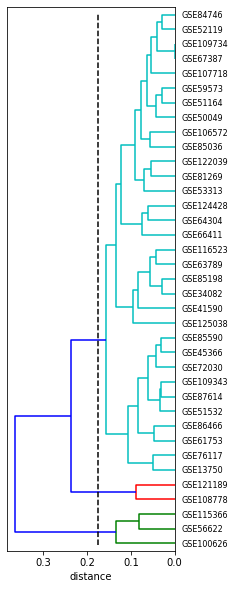

In [15]:
# calculate full dendrogram
plt.figure(figsize=(3, 10))
plt.xlabel('distance')
plt.yticks([])
dendrogram(
    Z,
    orientation = 'left',
    color_threshold=max_d,
    labels = labels
)
plt.plot([max_d,max_d],[4,366],c='black',linewidth=1.5,linestyle ='--')
#plt.savefig('recluster_dendrogram_ref.svg')
plt.show()

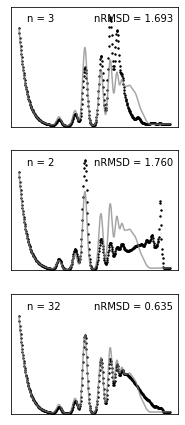

In [17]:
#prepare meta polysome plots by averaging peaks of individual clusters
fig,ax = plt.subplots(len(np.unique(clusters)),1,figsize=(3,len(np.unique(clusters))*2.5))
#process each cluster by number
for cluster in np.unique(clusters):
    cluster_no = cluster -1
    #select the peak volumess corresponding to this cluster
    these_traces = poly_array[clusters == cluster]
    #calculate the nrmsd for these_traces
    nrmsd_vals = []
    for trace in these_traces:
        nrmsd_vals.append(polyan.nrmsd_profile(trace,exp_peaks))
    av_nrmsd = np.mean(nrmsd_vals)
    #calculate the average polysome profile for this cluster
    x,y = polyan.plot_poly(np.mean(these_traces,axis=0))
    #plot along with reference
    ax[cluster_no].plot(x_ref,y_ref,c='grey',alpha=0.7)
    ax[cluster_no].scatter(x,y,s=2,c='black')
    ax[cluster_no].text(0.05,7,'n = ' + str(len(these_traces)))
    ax[cluster_no].text(0.5,7,'nRMSD = %1.3f' % av_nrmsd)
    ax[cluster_no].set_ylim((0,8))
    ax[cluster_no].set_yticks([])
    ax[cluster_no].set_xticks([])
#plt.savefig('re_clusters_ref.svg')
plt.show()